In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib.util
import sys
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from datetime import datetime
from IPython.display import display  # Jupyter-safe
from io import StringIO
import csv
import json

In [2]:
torch_spec = importlib.util.find_spec("torch")
print(torch_spec)

ModuleSpec(name='torch', loader=<_frozen_importlib_external.SourceFileLoader object at 0x14e4ceec0>, origin='/Users/whiskymisky/opt/anaconda3/envs/masters/lib/python3.10/site-packages/torch/__init__.py', submodule_search_locations=['/Users/whiskymisky/opt/anaconda3/envs/masters/lib/python3.10/site-packages/torch'])


Params

In [3]:
# Parameters
aligned_data_root = Path("aligned_dataset")
window_size = 50


Load and Accumulate Data Across Trials

In [4]:
# Storage for all trials
X_trials = []
y_trials = []

# Load aligned IMU and angle data from all trials
for trial_dir in sorted(aligned_data_root.glob("trial_*")):
    X_path = trial_dir / "X.csv"
    y_path = trial_dir / "Y.csv"
    if not X_path.exists() or not y_path.exists():
        print(f"Missing data in {trial_dir}, skipping.")
        continue

    X_df = pd.read_csv(X_path)
    y_df = pd.read_csv(y_path)

    # Drop unnecessary columns
    X_df = X_df.drop(columns=['Millis'], errors='ignore')
    y_df = y_df.drop(columns=['time'], errors='ignore')

    assert len(X_df) == len(y_df), f"Length mismatch in {trial_dir}"

    X_trials.append(X_df.values)
    y_trials.append(y_df.values)


 Concatenate and Normalize

In [5]:
# Concatenate all trials
X_all = np.concatenate(X_trials, axis=0)
y_all = np.concatenate(y_trials, axis=0)

# Scale features and targets
scaler_X = StandardScaler().fit(X_all)
scaler_y = StandardScaler().fit(y_all)

X_all_scaled = scaler_X.transform(X_all)
y_all_scaled = scaler_y.transform(y_all)


Apply Sliding Window

In [6]:
def create_windows(X, y, window_size):
    X_windowed = []
    y_windowed = []
    for i in range(len(X) - window_size + 1):
        X_windowed.append(X[i:i+window_size])
        y_windowed.append(y[i+window_size-1])  # predict last frame
    return np.array(X_windowed), np.array(y_windowed)

X_all, y_all = create_windows(X_all_scaled, y_all_scaled, window_size)


Train/Validation/Test Split

In [7]:
# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.4, random_state=42
)

# Second split: 20% val, 20% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


Wrap in PyTorch Datasets and Check Shapes

In [8]:
# Wrap in PyTorch datasets
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

# Sanity check
x0, y0 = train_dataset[0]
print("Sample input shape:", x0.shape)
print("Sample target shape:", y0.shape)


Sample input shape: torch.Size([50, 30])
Sample target shape: torch.Size([24])


In [9]:
X_df

,AccelX_chest,AccelY_chest,AccelZ_chest,GyroX_chest,GyroY_chest,GyroZ_chest,AccelX_right_leg,AccelY_right_leg,AccelZ_right_leg,GyroX_right_leg,...,AccelZ_right_arm,GyroX_right_arm,GyroY_right_arm,GyroZ_right_arm,AccelX_left_arm,AccelY_left_arm,AccelZ_left_arm,GyroX_left_arm,GyroY_left_arm,GyroZ_left_arm
0,-0.974,-0.158,0.247,-4.340,-0.910,-11.060,-0.989,-0.250,0.010,0.000,...,-0.051,-13.580,-6.230,-1.330,-0.797,-0.447,-0.423,-7.350,2.170,-0.140
1,-0.980,-0.165,0.252,-3.792,-1.534,-11.004,-0.984,-0.252,0.011,-0.122,...,-0.042,-12.654,-8.077,0.058,-0.792,-0.451,-0.419,-6.227,2.173,-0.279
2,-0.983,-0.164,0.261,-3.929,-3.166,-10.819,-0.987,-0.245,0.009,-0.190,...,-0.096,-8.432,-8.326,1.572,-0.796,-0.450,-0.426,-4.230,2.706,-0.079
3,-0.979,-0.163,0.258,-4.627,-5.351,-10.670,-0.989,-0.243,0.006,-0.582,...,-0.087,-9.703,-7.385,3.721,-0.807,-0.433,-0.432,-3.994,2.045,-0.338
4,-0.971,-0.178,0.250,-4.464,-6.365,-10.485,-0.988,-0.245,0.005,-0.766,...,-0.047,-10.517,-10.129,3.406,-0.807,-0.419,-0.436,-6.260,0.949,-1.591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,-0.940,-0.069,0.031,-6.115,-1.804,4.283,-0.969,-0.289,-0.103,-9.457,...,-0.168,-14.638,4.156,-17.374,-0.763,0.152,-0.485,8.219,28.189,29.638
8668,-0.944,-0.091,0.038,2.332,-5.765,2.600,-0.926,-0.299,-0.056,-3.912,...,-0.173,-16.731,0.340,-8.773,-0.792,0.125,-0.455,12.960,20.106,34.967
8669,-0.967,-0.112,0.054,9.001,-8.268,2.011,-0.921,-0.247,-0.058,-6.688,...,-0.175,-15.440,-1.678,-0.449,-0.754,0.192,-0.370,23.668,15.518,38.936
8670,-0.995,-0.118,0.066,13.113,-8.690,1.190,-0.944,-0.206,-0.138,-11.573,...,-0.191,-10.556,-1.145,9.450,-0.721,0.279,-0.408,20.761,21.690,34.221


In [10]:
y_df

,right ankle,left ankle,right knee,left knee,right hip,left hip,right shoulder,left shoulder,right elbow,left elbow,...,right thigh,left thigh,pelvis,trunk,shoulders,head,right arm,left arm,right forearm,left forearm
0,-38.866456,-68.533373,7.446345,5.135329,2.958860,3.836582,9.499746,8.100783,-6.346643,-7.807354,...,-82.818647,-81.940925,2.390685,93.411106,0.944986,85.548986,-76.277761,-77.676724,-82.624404,-85.484078
1,-38.343883,-67.663694,7.098845,5.211061,2.763779,3.813969,9.576901,7.943975,-6.655394,-8.003499,...,-82.907602,-81.857412,2.413493,93.304981,0.619276,85.720766,-76.094480,-77.727406,-82.749874,-85.730905
2,-38.564056,-68.091949,7.233265,5.214349,2.744306,3.736667,9.660954,7.744906,-6.794059,-8.090523,...,-82.852892,-81.860531,2.423980,93.230797,0.349706,85.798934,-75.936244,-77.852291,-82.730303,-85.942814
3,-38.867967,-68.663526,7.427086,5.242732,2.715914,3.650176,9.714999,7.533809,-6.846494,-8.130385,...,-82.788269,-81.854007,2.426682,93.137782,0.094621,85.755406,-75.789184,-77.970374,-82.635678,-86.100759
4,-39.087929,-69.071104,7.536546,5.309117,2.611634,3.531403,9.696660,7.321739,-6.858430,-8.130518,...,-82.750948,-81.831179,2.425955,92.996181,-0.150368,85.646848,-75.665922,-78.040843,-82.524352,-86.171361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,-22.447342,-607.760028,188.743687,-358.873602,-1.881603,10.083178,188.850720,-699.471566,721.165087,-556.179930,...,-89.796738,-77.831958,5.459484,95.548735,8.988479,77.853373,-79.064415,-787.386702,102.100672,-263.566631
8668,-21.076632,-609.004113,189.223845,-358.897816,-2.075384,10.120379,188.626724,-699.752464,721.522086,-556.221750,...,-89.859490,-77.663727,5.402113,95.417706,8.997585,77.754060,-79.157382,-787.536570,102.364704,-263.758320
8669,-19.904360,-609.743294,189.539555,-358.854063,-2.330769,10.171159,188.502615,-700.206764,721.620868,-556.028654,...,-89.967538,-77.465611,5.350489,95.270369,8.890905,77.469419,-79.134155,-787.843534,102.486713,-263.872188
8670,-19.493500,-609.548309,189.649674,-358.817074,-2.539074,10.227793,188.531232,-700.774812,721.432229,-555.489361,...,-90.069378,-77.302511,5.310810,95.163903,8.632980,77.080014,-78.999072,-788.305116,102.433158,-263.794477


# Model

Model Definition

In [11]:
class IMULSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, fc_hidden_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc_head = nn.Sequential(
            nn.Linear(hidden_size, fc_hidden_size),
            nn.ReLU(),
            nn.Linear(fc_hidden_size, output_size)
        )

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        last_step_output = out[:, -1, :]  # Take output from last timestep

        return self.fc_head(last_step_output)


R² Helper Function

In [12]:
def r2_score(pred, target):
    target_mean = torch.mean(target, dim=0)
    ss_total = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - pred) ** 2)
    return 1 - (ss_res / ss_total)

Logging Setup

In [13]:
# Setup log directory
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
log_dir = os.path.join('logs', f'run_{timestamp}')
os.makedirs(log_dir, exist_ok=True)

LOG_PATH = os.path.join(log_dir, 'training_log.txt')
csv_path = os.path.join(log_dir, 'metrics.csv')
SAVE_STDOUT = True  # If True, also print to terminal


CSV Logging Setup

In [14]:
# Metrics CSV setup
csv_fields = ['epoch', 'train_mse', 'train_mae', 'train_rmse', 'train_r2',
              'val_mse', 'val_mae', 'val_rmse', 'val_r2']

csv_file = open(csv_path, mode='w', newline='')
csv_writer = csv.DictWriter(csv_file, fieldnames=csv_fields)
csv_writer.writeheader()


79

Logger Class

In [15]:
class DualLogger:
    def __init__(self, filepath, print_to_stdout=True):
        self.log_file = open(filepath, 'w')
        self.print_to_stdout = print_to_stdout

    def log(self, text):
        self.log_file.write(text + '\n')
        self.log_file.flush()
        if self.print_to_stdout:
            print(text)

    def close(self):
        self.log_file.close()

logger = DualLogger(LOG_PATH, print_to_stdout=SAVE_STDOUT)


Hyperparameters and Summary

In [16]:
# Hyperparameters
hidden_size = 128
num_layers = 2
batch_size = 32
epochs = 20
learning_rate = 1e-3

# Show config info
print("=" * 70)
print(f"Training started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print(f"Hyperparameters:")
print(f"  Hidden Size   = {hidden_size}")
print(f"  Num Layers    = {num_layers}")
print(f"  Batch Size    = {batch_size}")
print(f"  Epochs        = {epochs}")
print(f"  Learning Rate = {learning_rate}")
print(f"  Window Size   = {window_size}")
print("=" * 70)

# Save config to file
hyperparams = {
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
    "window_size": window_size,
}
with open(os.path.join(log_dir, 'hyperparameters.json'), 'w') as f:
    json.dump(hyperparams, f, indent=2)


Training started: 2025-04-13 12:32:27
Device: CPU
Hyperparameters:
  Hidden Size   = 128
  Num Layers    = 2
  Batch Size    = 32
  Epochs        = 20
  Learning Rate = 0.001
  Window Size   = 50


Model, Optimizer, Dataloaders

In [17]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model setup
input_size = train_dataset[0][0].shape[1]
output_size = train_dataset[0][1].shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = IMULSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
mse_loss_fn = nn.MSELoss()
mae_loss_fn = nn.L1Loss()


Training Loop

In [18]:
logger.log(f"\nStarting training for {epochs} epochs...\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    logger.log(f"Epoch {epoch+1}/{epochs}")
    train_loss_mse = 0
    train_loss_mae = 0
    train_r2_total = 0
    train_samples = 0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        pred = model(X_batch)
        loss_mse = mse_loss_fn(pred, y_batch)
        loss_mae = mae_loss_fn(pred, y_batch)

        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()

        batch_size_actual = X_batch.size(0)
        train_loss_mse += loss_mse.item() * batch_size_actual
        train_loss_mae += loss_mae.item() * batch_size_actual
        train_r2_total += r2_score(pred, y_batch).item() * batch_size_actual
        train_samples += batch_size_actual

        running_loss += loss_mse.item()
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
            avg_batch_loss = running_loss / min(100, (batch_idx + 1))
            logger.log(f"  Batch {batch_idx+1:>4}/{len(train_loader)} - Running MSE Loss: {avg_batch_loss:.4f}")
            running_loss = 0.0

    avg_train_mse = train_loss_mse / train_samples
    avg_train_mae = train_loss_mae / train_samples
    avg_train_rmse = avg_train_mse ** 0.5
    avg_train_r2 = train_r2_total / train_samples

    # Validation loop
    model.eval()
    val_loss_mse = 0
    val_loss_mae = 0
    val_r2_total = 0
    val_samples = 0

    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            pred = model(X_val)

            loss_mse = mse_loss_fn(pred, y_val)
            loss_mae = mae_loss_fn(pred, y_val)

            val_loss_mse += loss_mse.item() * X_val.size(0)
            val_loss_mae += loss_mae.item() * X_val.size(0)
            val_r2_total += r2_score(pred, y_val).item() * X_val.size(0)
            val_samples += X_val.size(0)

    avg_val_mse = val_loss_mse / val_samples
    avg_val_mae = val_loss_mae / val_samples
    avg_val_rmse = avg_val_mse ** 0.5
    avg_val_r2 = val_r2_total / val_samples

    # Epoch summary
    logger.log(f"  ↳ Train → MSE: {avg_train_mse:.4f}, MAE: {avg_train_mae:.4f}, RMSE: {avg_train_rmse:.4f}, R²: {avg_train_r2:.4f}")
    logger.log(f"  ↳ Val   → MSE: {avg_val_mse:.4f}, MAE: {avg_val_mae:.4f}, RMSE: {avg_val_rmse:.4f}, R²: {avg_val_r2:.4f}")
    logger.log("-" * 70)

    # Write to CSV
    csv_writer.writerow({
        'epoch': epoch + 1,
        'train_mse': avg_train_mse,
        'train_mae': avg_train_mae,
        'train_rmse': avg_train_rmse,
        'train_r2': avg_train_r2,
        'val_mse': avg_val_mse,
        'val_mae': avg_val_mae,
        'val_rmse': avg_val_rmse,
        'val_r2': avg_val_r2,
    })
    csv_file.flush()

# After training
csv_file.close()
logger.close()



Starting training for 20 epochs...

Epoch 1/20
  Batch  100/1716 - Running MSE Loss: 0.8185
  Batch  200/1716 - Running MSE Loss: 0.7137
  Batch  300/1716 - Running MSE Loss: 0.6442
  Batch  400/1716 - Running MSE Loss: 0.5719
  Batch  500/1716 - Running MSE Loss: 0.4978
  Batch  600/1716 - Running MSE Loss: 0.4159
  Batch  700/1716 - Running MSE Loss: 0.3955
  Batch  800/1716 - Running MSE Loss: 0.4042
  Batch  900/1716 - Running MSE Loss: 0.3478
  Batch 1000/1716 - Running MSE Loss: 0.3710
  Batch 1100/1716 - Running MSE Loss: 0.3153
  Batch 1200/1716 - Running MSE Loss: 0.3048
  Batch 1300/1716 - Running MSE Loss: 0.2749
  Batch 1400/1716 - Running MSE Loss: 0.2316
  Batch 1500/1716 - Running MSE Loss: 0.2601
  Batch 1600/1716 - Running MSE Loss: 0.2320
  Batch 1700/1716 - Running MSE Loss: 0.2249
  Batch 1716/1716 - Running MSE Loss: 0.0354
  ↳ Train → MSE: 0.4115, MAE: 0.3920, RMSE: 0.6415, R²: 0.5696
  ↳ Val   → MSE: 0.2330, MAE: 0.2956, RMSE: 0.4827, R²: 0.7539
----------------

Target Distribution Inspection

In [19]:
# Inspect target (y) distribution in training and validation sets
train_y = train_dataset[:][1]
val_y = val_dataset[:][1]

print("Train y mean/std:", train_y.mean().item(), train_y.std().item())
print("Val   y mean/std:", val_y.mean().item(), val_y.std().item())
print("Train y min/max:", train_y.min().item(), train_y.max().item())
print("Val   y min/max:", val_y.min().item(), val_y.max().item())


Train y mean/std: -5.798945858259685e-05 0.9995862245559692
Val   y mean/std: -0.0011334916343912482 1.0013878345489502
Train y min/max: -9.705154418945312 8.683670043945312
Val   y min/max: -9.726888656616211 8.679986953735352


Save Model Weights

In [20]:
# Save the trained model weights
torch.save(model.state_dict(), "imu_lstm_weights.pth")

Setup for Test Evaluation

In [21]:
# Define loss function (if not already defined)
criterion = nn.MSELoss()

# Wrap test data into a Dataset and DataLoader
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

Run Test Evaluation

In [ ]:
# Evaluate model on test set
model.eval()
test_loss = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        pred = model(X_test_batch)
        loss = criterion(pred, y_test_batch)

        test_loss += loss.item() * X_test_batch.size(0)

        all_preds.append(pred.cpu())
        all_targets.append(y_test_batch.cpu())

test_loss /= len(test_dataset)
print(f"Test MSE Loss: {test_loss:.4f}")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true = torch.cat(all_targets).numpy()
y_pred = torch.cat(all_preds).numpy()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")


Test MSE Loss: 0.0108


Convert Test Outputs to NumPy (Optional for Analysis/Plotting)

In [23]:
# Convert predictions and targets to NumPy for visualization or metrics
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

In [24]:
print(all_preds.shape, all_targets.shape)
print(scaler_y)


(18297, 24) (18297, 24)
StandardScaler()


✅ Best joints (lowest RMSE):
       Joint       MSE      RMSE       MAE        R2
16  joint_16  1.192342  1.091944  0.845133  0.973985
17  joint_17  4.283512  2.069665  1.474764  0.989105
15  joint_15  4.635018  2.152909  1.519872  0.971776
18  joint_18  5.138237  2.266768  1.642419  0.987819
14  joint_14  5.502035  2.345642  1.538336  0.967546

⚠️ Worst joints (highest RMSE):
       Joint          MSE       RMSE        MAE        R2
7    joint_7  2041.772949  45.185982  29.616583  0.993819
0    joint_0  2325.375732  48.222150  27.855186  0.990370
8    joint_8  2345.965576  48.435169  33.167774  0.990942
9    joint_9  2624.193604  51.226884  35.393059  0.991425
23  joint_23  3837.695312  61.949135  43.549709  0.990721


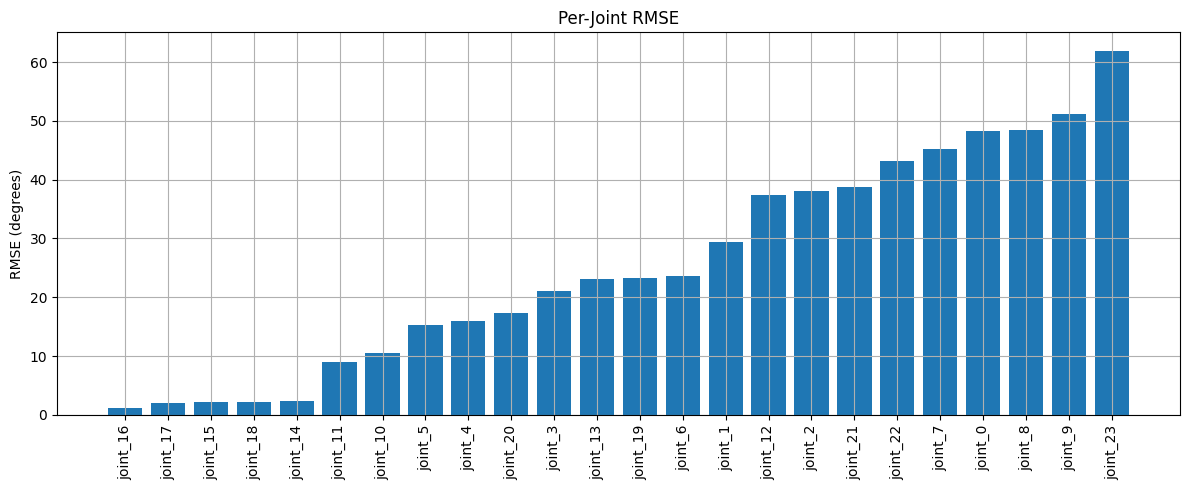

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Inverse transform predictions and targets
y_pred_orig = scaler_y.inverse_transform(all_preds)
y_true_orig = scaler_y.inverse_transform(all_targets)

# Step 2: Compute per-joint errors
n_joints = y_true_orig.shape[1]
mse_list = []
rmse_list = []
mae_list = []
r2_list = []

for i in range(n_joints):
    mse = mean_squared_error(y_true_orig[:, i], y_pred_orig[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_orig[:, i], y_pred_orig[:, i])
    r2 = r2_score(y_true_orig[:, i], y_pred_orig[:, i])
    
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

# Step 3: Organize into a DataFrame
import pandas as pd
joint_names = [f"joint_{i}" for i in range(n_joints)]
joint_errors = pd.DataFrame({
    "Joint": joint_names,
    "MSE": mse_list,
    "RMSE": rmse_list,
    "MAE": mae_list,
    "R2": r2_list
}).sort_values(by="RMSE")

# Step 4: Show best/worst joints
print("✅ Best joints (lowest RMSE):")
print(joint_errors.head(5))
print("\n⚠️ Worst joints (highest RMSE):")
print(joint_errors.tail(5))

# Step 5 (Optional): Plot RMSE by joint
plt.figure(figsize=(12, 5))
plt.bar(joint_errors["Joint"], joint_errors["RMSE"])
plt.xticks(rotation=90)
plt.ylabel("RMSE (degrees)")
plt.title("Per-Joint RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()


PLOTS

✅ Saved: training_validation_metrics.png and training_validation_metrics.pdf


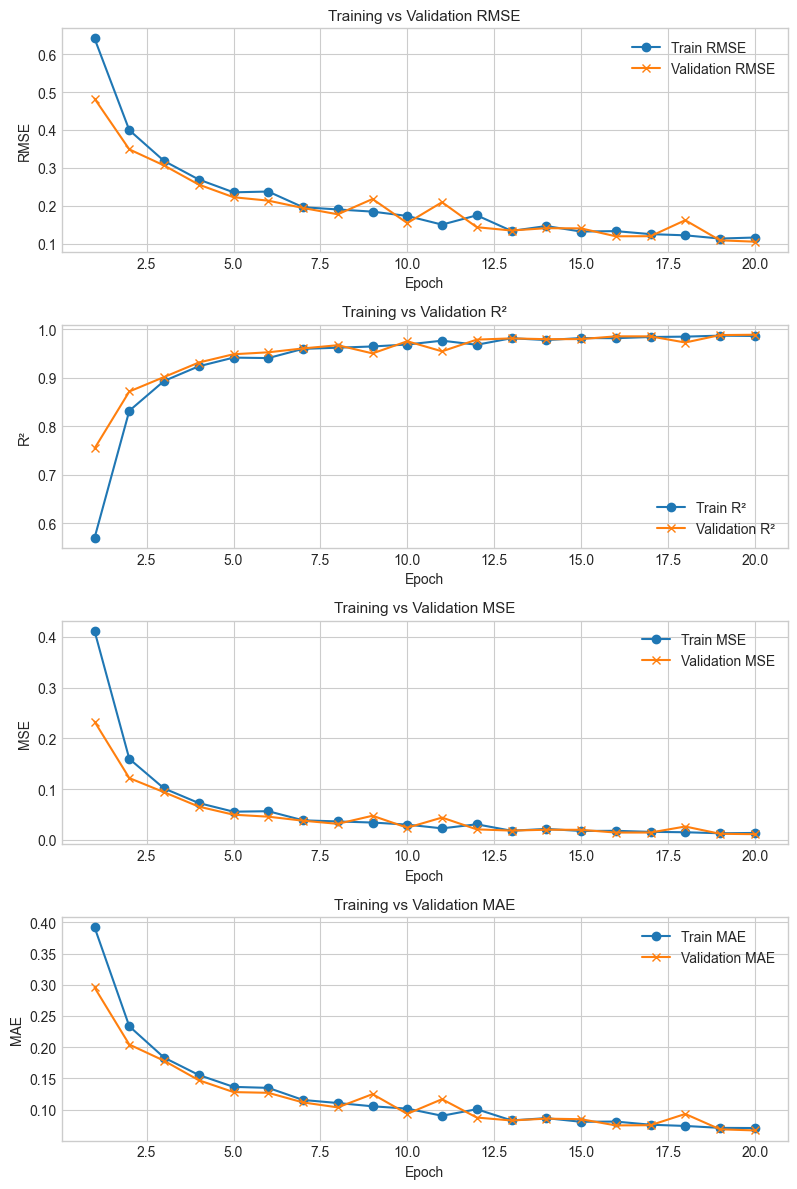

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Metrics CSV ---
metrics_path = "logs/run_2025-04-13_12-32-27/metrics.csv"  # Adjust path if needed
df = pd.read_csv(metrics_path)

# --- Plot Configuration ---
plt.style.use("seaborn-v0_8-whitegrid")  # for Matplotlib 3.6+

fig, axs = plt.subplots(4, 1, figsize=(8, 12))

metrics = [
    ("train_rmse", "val_rmse", "RMSE"),
    ("train_r2", "val_r2", "R²"),
    ("train_mse", "val_mse", "MSE"),
    ("train_mae", "val_mae", "MAE")
]

for idx, (train_col, val_col, label) in enumerate(metrics):
    axs[idx].plot(df["epoch"], df[train_col], label=f"Train {label}", marker='o')
    axs[idx].plot(df["epoch"], df[val_col], label=f"Validation {label}", marker='x')
    axs[idx].set_title(f"Training vs Validation {label}", fontsize=11)
    axs[idx].set_xlabel("Epoch")
    axs[idx].set_ylabel(label)
    axs[idx].legend()
    axs[idx].grid(True)

plt.tight_layout()

# --- Save Plots ---
fig.savefig("training_validation_metrics.png", dpi=300)
fig.savefig("training_validation_metrics.pdf")

print("✅ Saved: training_validation_metrics.png and training_validation_metrics.pdf")
